In [19]:
import matplotlib

matplotlib.use("nbagg")
import math

import matplotlib.animation as anm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np


In [20]:
class World:
    def __init__(self, time_span, time_interval, debug=False):
        self.objects = []
        self.debug = debug
        # シミュレーション時間[s]
        self.time_span = time_span
        # 移動時間[s]
        self.time_interval = time_interval

    def append(self, obj):  # オブジェクトを登録するための関数
        self.objects.append(obj)

    def draw(self):
        fig = plt.figure(figsize=(4, 4))  # 8x8 inchの図を準備
        ax = fig.add_subplot(111)  # サブプロットを準備
        ax.set_aspect("equal")  # 縦横比を座標の値と一致させる
        ax.set_xlim(-5, 5)  # X軸を-5m x 5mの範囲で描画
        ax.set_ylim(-5, 5)  # Y軸も同様に
        ax.set_xlabel("X", fontsize=10)  # X軸にラベルを表示
        ax.set_ylabel("Y", fontsize=10)  # 同じくY軸に

        elems = []

        if self.debug:
            for i in range(int(self.time_span / self.time_interval)):
                self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(
                fig,
                self.one_step,
                fargs=(elems, ax),
                frames=int(self.time_span / self.time_interval) + 1,
                interval=int(self.time_interval * 1000),
                repeat=False,
            )
            plt.show()

    def one_step(self, i, elems, ax):  ### fig:one_step_add_one_step
        while elems:
            elems.pop().remove()
        time_str = "t = %.2f[s]" % (self.time_interval * i)  # 時刻として表示する文字列
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"):
                obj.one_step(self.time_interval)


In [21]:
class IdealRobot:  ### fig:rewrite_init_for_agent
    def __init__(self, pose, agent=None, sensor=None, color="black"):  # agentという引数を追加
        self.pose = pose
        self.r = 0.2
        self.color = color
        self.agent = agent
        self.poses = [pose]  # 軌跡の描画用。追加
        self.sensor = sensor

    def draw(self, ax, elems):  ###idealrobot6draw
        x, y, theta = self.pose  # ここから15行目までは変えなくて良い
        xn = x + self.r * math.cos(theta)
        yn = y + self.r * math.sin(theta)
        elems += ax.plot([x, xn], [y, yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color)
        elems.append(ax.add_patch(c))

        self.poses.append(self.pose)  # 以下追加。軌跡の描画
        elems += ax.plot(
            [e[0] for e in self.poses],
            [e[1] for e in self.poses],
            linewidth=0.5,
            color="black",
        )
        if self.sensor and len(self.poses) > 1:
            # 最後から2番目にアクセス？
            self.sensor.draw(ax, elems, self.poses[-2])
        if self.agent and hasattr(self.agent,"draw"):
            self.agent.draw(ax, elems)
    @classmethod
    def state_transition(cls, nu, omega, time, pose):
        """移動後の姿勢を返す

        ある時刻の姿勢が制御指令(nu,omega)で時刻t間動いたあとの姿勢を計算する。

        Args:
            nu (_type_): 移動速度[m/s]
            omega (_type_): 移動方向[rad/s]
            time (_type_): 移動時間
            pose (_type_): 移動前の姿勢

        Returns:
            _type_: 移動後の姿勢
        """
        t0 = pose[2]
        if math.fabs(omega) < 1e-10:  # 角速度がほぼゼロの場合とそうでない場合に場合分け
            return pose + np.array([nu * math.cos(t0), nu * math.sin(t0), omega]) * time
        else:
            return pose + np.array(
                [
                    nu / omega * (math.sin(t0 + omega * time) - math.sin(t0)),
                    nu / omega * (-math.cos(t0 + omega * time) + math.cos(t0)),
                    omega * time,
                ]
            )

    def one_step(self, time_interval):
        if not self.agent:
            return

        obs = self.sensor.data(self.pose) if self.sensor else None  # 追加
        nu, omega = self.agent.decision(obs)
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)


In [22]:
class Agent:
    """ロボットの制御指令を決定するエージェントクラス
    エージェント=ロボットをどのように動かすか、その考える主体
    """

    def __init__(self, nu, omega):
        self.nu = nu
        self.omega = omega

    def decision(self, observation=None):
        return self.nu, self.omega


In [23]:
class Landmark:  ### fig:class_landmark
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None

    def draw(self, ax, elems):
        c = ax.scatter(
            self.pos[0],
            self.pos[1],
            s=100,
            marker="*",
            label="landmarks",
            color="orange",
        )
        elems.append(c)
        elems.append(
            ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10)
        )


In [24]:
class Map:  ### fig:class_map
    def __init__(self):
        self.landmarks = []  # 空のランドマークのリストを準備

    def append_landmark(self, landmark):  # ランドマークを追加
        landmark.id = len(self.landmarks)  # 追加するランドマークにIDを与える
        self.landmarks.append(landmark)

    def draw(self, ax, elems):  # 描画（Landmarkのdrawを順に呼び出し）
        for lm in self.landmarks:
            lm.draw(ax, elems)


In [25]:
class IdealCamera:
    def __init__(
        self,
        env_map,
        distance_range=(0.5, 6.0),
        direction_range=(-math.pi / 3, math.pi / 3),
    ):
        self.map = env_map
        self.lastdata = []

        self.distance_range = distance_range
        self.direction_range = direction_range

    def visible(self, polarpos):
        # ランドマークが計測できる条件
        if polarpos is None:
            return False

        return (
            self.distance_range[0] <= polarpos[0] <= self.distance_range[1]
            and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
        )

    def data(self, cam_pose):
        """cam_poseから見たランドマークまでの距離と方向を返す

        Args:
            cam_pose (_type_): カメラ姿勢（＝ロボット姿勢）

        Returns:
            _type_: 全てのランドマークまでの距離と方向
        """
        observed = []
        for lm in self.map.landmarks:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):
                observed.append((z, lm.id))

        self.lastdata = observed
        return observed

    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        """観測関数h
        ロボットから見たランドマークまでの距離と向きを算出する（＝センサー値）

        Args:
            cam_pose (_type_): カメラ姿勢（＝ロボット姿勢）
            obj_pos (_type_): ランドマーク姿勢（座標）

        Returns:
            _type_: ランドマークまでの距離と方向
        """
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi:
            phi -= 2 * np.pi
        while phi < -np.pi:
            phi += 2 * np.pi
        # *diffはdiffの各要素がx,yとしてhypotに渡される。
        return np.array([np.hypot(*diff), phi]).T

    def draw(self, ax, elems, cam_pose):
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x, lx], [y, ly], color="pink")


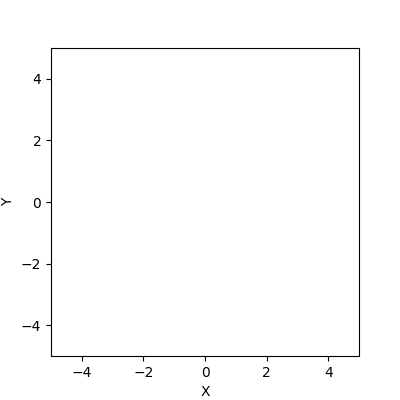

In [26]:
if __name__=="__main__":

    world = World(10, 0.1)

    # 地図を作成し3つのランドマークを追加abs
    m = Map()
    m.append_landmark(Landmark(2, -2))
    m.append_landmark(Landmark(-1, -3))
    m.append_landmark(Landmark(3, 3))
    world.append(m)

    ### ロボットを作る ###
    straight = Agent(0.2, 0.0)
    circling = Agent(0.2, 10.0 / 180 * math.pi)
    robot1 = IdealRobot(
        np.array([2, 3, math.pi / 6]).T, 
        sensor=IdealCamera(m), 
        agent=straight
    )
    robot2 = IdealRobot(
        np.array([-2, -1, math.pi / 5 * 6]).T,
        sensor=IdealCamera(m),
        agent=circling, 
        color="red"
    )
    #robot3 = IdealRobot(np.array([0, 0, 0]).T, color="blue")
    world.append(robot1)
    world.append(robot2)
    #world.append(robot3)


    %matplotlib widget
    world.draw()

In [27]:
# robot2から見たランドマークまでの距離と方向を算出
cam = IdealCamera(m)
p = cam.data(robot2.pose)
print(p)


[]


In [29]:
import sys
sys.path.append("../scripts")
from ideal_robot import *